In [1]:
import os

os.chdir("..")

In [2]:
# Select GPUs to use
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,2,3,6'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import random
import time
import datetime

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix
)

# Transformers
import torch
from torch.nn import BCEWithLogitsLoss, DataParallel
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import RAdam
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup 

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

In [6]:
# Use GPU
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## 1. Load and transform data

In [7]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [8]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [9]:
# Split into 70% training, 15% validation, and 15% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.3)
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_test, Y_test, test_size=0.5)

In [10]:
# Load tokenizer
tokenizer = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096")

In [11]:
# Function to split a CSR and its corresponding label into encoding chunks of 4096 tokens

def split_doc_into_encoding_chunks_with_labels(doc, label):

    # Initialize lists to store encodings
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    # Tokenize document without adding cls and sep token
    encoding = tokenizer(doc, add_special_tokens=False)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Split encoding into chunks of 4096

    start = 0 # Starting position for chunking
    window_size = 4094  # we take 2 off here so that we can fit in our [s] and [SEP] tokens
    total_len = len(input_ids)

    loop = True
    while loop:
        # End position = start + window_size
        end = start + window_size
        # If end position is greater than total length, stop and change endpoint to the final token position
        if end >= total_len:
            loop = False
            end = total_len
        # (1) Extract window from input_ids and attention_mask
        input_ids_chunk = input_ids[start:end]
        attention_mask_chunk = attention_mask[start:end]
        # (2) Add [s] and [SEP] tokens (0 and 2 in Longformer)
        input_ids_chunk = [0] + input_ids_chunk + [2]
        attention_mask_chunk = [1] + attention_mask_chunk + [1]
        # (3) Add padding up to window_size + 2 tokens
        input_ids_chunk += [0] * (window_size - len(input_ids_chunk) + 2)
        attention_mask_chunk += [0] * (window_size - len(attention_mask_chunk) + 2)
        # (4) Format into PyTorch tensors
        input_ids_list.append(input_ids_chunk)
        attention_mask_list.append(attention_mask_chunk)
        # (5) Store label
        label_list.append(label)
        # Move the window to the next 4096 tokens
        start = end

    # Create dictionary from lists
    encoding_dict = {
        'input_ids': torch.Tensor(input_ids_list).long(),
        'attention_mask': torch.Tensor(attention_mask_list).long(),
        'label': torch.Tensor(label_list).float()
    }

    return encoding_dict

In [12]:
# Function to create a dict for the training/ validation set

def create_encoding_label_dict(X, Y):
    
    X = list(X)

    i = 0
    # Iterate through CSRs
    for i in tqdm(range(len(X))):
        # Encode doc
        encoding_dict = split_doc_into_encoding_chunks_with_labels(X[i], Y[i])
        if i == 0:
            # Initialize dict
            encoding_dict_full = encoding_dict
        else:
            # Append dict
            encoding_dict_full['input_ids'] = torch.cat([encoding_dict_full['input_ids'], encoding_dict['input_ids']])
            encoding_dict_full['attention_mask'] = torch.cat([encoding_dict_full['attention_mask'], encoding_dict['attention_mask']])
            encoding_dict_full['label'] = torch.cat([encoding_dict_full['label'], encoding_dict['label']])
        i += 1
    
    return encoding_dict_full

In [13]:
# Encode data
train_encodings = create_encoding_label_dict(X_train, Y_train)
val_encodings = create_encoding_label_dict(X_val, Y_val)

  0%|          | 0/5485 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (38079 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/1310 [00:00<?, ?it/s]

In [14]:
# Convert data into TensorDatasets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_encodings['label'])
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_encodings['label'])

In [15]:
# Create the DataLoader

batch_size = 8
    
train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle = True)

## 2. Load model

In [16]:
# Load model
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", problem_type="multi_label_classification", num_labels=13)
model = DataParallel(model)
model.to(device)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

DataParallel(
  (module): LongformerForSequenceClassification(
    (longformer): LongformerModel(
      (embeddings): LongformerEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(4098, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): LongformerEncoder(
        (layer): ModuleList(
          (0): LongformerLayer(
            (attention): LongformerAttention(
              (self): LongformerSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (query_global): Linear(in_features=768, out_features=768, bias=True)
                (key_global): Linear(in

## 3. Train

In [17]:
# Define helper functions

# Function to calculate the weights for the positive class
def calculate_pos_weights(labels):
    pos_counts = labels.sum(axis=0)
    neg_counts = len(labels) - pos_counts
    pos_weights = neg_counts / (pos_counts + 1e-5)
    return torch.as_tensor(pos_weights, dtype=torch.float)

# Function to format a time in seconds into a string hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [18]:
# Prepare training

# Parameters
epochs = 5
learning_rate = 2e-5 #5e-6
warumup_steps = 0

# Optimizer
optimizer = RAdam(model.parameters(), lr=learning_rate)

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler (linear decreasing lr without warmup)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warumup_steps, 
                                            num_training_steps = total_steps)

# Calculate the weights for the positive class for the training data
pos_weight = calculate_pos_weights(Y_train)

# Training with BCEWithLogitsLoss instead of CrossEntropyLoss()
loss_fct_train = BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
loss_fct_val = BCEWithLogitsLoss()

In [19]:
# Training

# Store training and validation loss, validation F1 score, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Print progress update 
        if step % 100 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack the batch from the dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch) and return the loss (because we provided labels) and the logits
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        logits = result.logits
        loss = loss_fct_train(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0. to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
    
    predictions , true_labels = [], []

    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        
        # Unpack the batch from the dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model
        logits = result.logits
        loss = loss_fct_val(logits, b_labels)
            
        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
    # Report the final macro F1 score for this validation run
    predicted_labels = torch.round(torch.sigmoid(torch.Tensor(np.concatenate(predictions, axis=0)))).numpy().astype(int)
    true_labels = np.concatenate(true_labels, axis=0).astype(int)
    avg_val_f1 = f1_score(predicted_labels, true_labels, average='macro')
    print("  Macro F1 score: {0:.2f}".format(avg_val_f1))    
    
    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Macro F1 score.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, 'models/longformer_full_text_epoch_' + str(epoch_i + 1) + '.pt')

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   100  of  5,992.    Elapsed: 0:04:35.
  Batch   200  of  5,992.    Elapsed: 0:08:59.
  Batch   300  of  5,992.    Elapsed: 0:13:27.
  Batch   400  of  5,992.    Elapsed: 0:17:58.
  Batch   500  of  5,992.    Elapsed: 0:22:30.
  Batch   600  of  5,992.    Elapsed: 0:27:02.
  Batch   700  of  5,992.    Elapsed: 0:31:32.
  Batch   800  of  5,992.    Elapsed: 0:36:05.
  Batch   900  of  5,992.    Elapsed: 0:40:35.
  Batch 1,000  of  5,992.    Elapsed: 0:45:01.
  Batch 1,100  of  5,992.    Elapsed: 0:49:29.
  Batch 1,200  of  5,992.    Elapsed: 0:54:00.
  Batch 1,300  of  5,992.    Elapsed: 0:58:31.
  Batch 1,400  of  5,992.    Elapsed: 1:03:01.
  Batch 1,500  of  5,992.    Elapsed: 1:07:30.
  Batch 1,600  of  5,992.    Elapsed: 1:12:00.
  Batch 1,700  of  5,992.    Elapsed: 1:16:24.
  Batch 1,800  of  5,992.    Elapsed: 1:20:51.
  Batch 1,900  of  5,992.    Elapsed: 1:25:19.
  Batch 2,000  of  5,992.    Elapsed: 1:29:48.
  Batch 2,100  of

  Batch 4,800  of  5,992.    Elapsed: 5:39:00.
  Batch 4,900  of  5,992.    Elapsed: 5:46:09.
  Batch 5,000  of  5,992.    Elapsed: 5:53:04.
  Batch 5,100  of  5,992.    Elapsed: 6:00:06.
  Batch 5,200  of  5,992.    Elapsed: 6:07:25.
  Batch 5,300  of  5,992.    Elapsed: 6:14:33.
  Batch 5,400  of  5,992.    Elapsed: 6:21:26.
  Batch 5,500  of  5,992.    Elapsed: 6:28:17.
  Batch 5,600  of  5,992.    Elapsed: 6:35:16.
  Batch 5,700  of  5,992.    Elapsed: 6:42:15.
  Batch 5,800  of  5,992.    Elapsed: 6:49:19.
  Batch 5,900  of  5,992.    Elapsed: 6:56:38.

  Average training loss: 0.14
  Training epoch took: 7:03:56

Running Validation...
  Macro F1 score: 0.80
  Validation Loss: 0.49
  Validation took: 0:48:15

======== Epoch 4 / 5 ========
Training...
  Batch   100  of  5,992.    Elapsed: 0:07:03.
  Batch   200  of  5,992.    Elapsed: 0:13:53.
  Batch   300  of  5,992.    Elapsed: 0:21:53.
  Batch   400  of  5,992.    Elapsed: 0:30:14.
  Batch   500  of  5,992.    Elapsed: 0:37:07.

In [20]:
# Look at training summary

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Macro F1 score.,Training Time,Validation Time
epoch,,,,,
1,0.391652,0.517439,0.734776,5:31:06,0:35:36
2,0.224337,0.480653,0.786832,5:15:16,0:39:29
3,0.136535,0.491524,0.797373,7:03:56,0:48:15
4,0.083624,0.523766,0.804942,6:53:47,0:40:06
5,0.056176,0.530264,0.808750,4:48:33,0:23:39


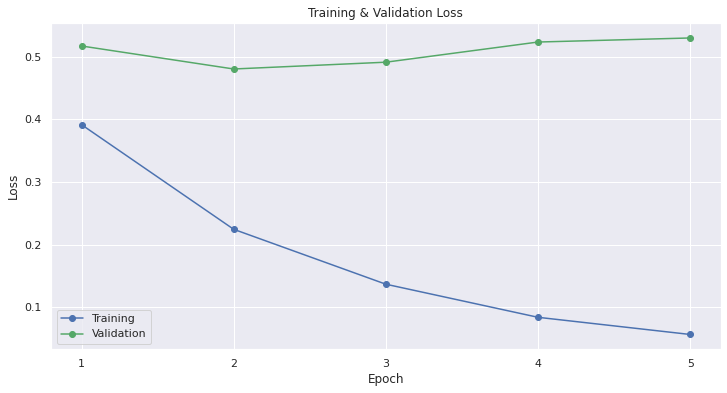

In [21]:
# Plot the learning curve

sns.set(style='darkgrid')
# sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1,epochs+1)))

plt.show()

In [22]:
# Restore best model

PATH = "models/longformer" + '_epoch_' + str(5) + '.pt'

#model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", problem_type="multi_label_classification", num_labels=13)
#model = DataParallel(model)
#model.to(device)
#optimizer = RAdam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## 4. Predict on test set
(Do not use batches, loop through CSRs and aggregate predicted labels)

In [22]:
# Predict each batch and use logical or for each label

X = list(X_test)
Y = Y_test

model.eval()

predictions = []

i = 0
# Iterate through CSRs
for i in tqdm(range(len(X))):
    # Encode doc
    encoding_dict = split_doc_into_encoding_chunks_with_labels(X[i], Y[i])
    num_chunks = len(encoding_dict['input_ids'])
    
    # Predict each chunk
    logits_list = []
    for c in range(num_chunks):
        input_ids = encoding_dict['input_ids'][c].to(device)
        attention_mask = encoding_dict['attention_mask'][c].to(device)
        # Forward pass
        with torch.no_grad():
            result = model(input_ids.unsqueeze(0),
                           token_type_ids=None,
                           attention_mask=attention_mask.unsqueeze(0),
                           return_dict=True)
        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Store logits
        logits_list.append(logits)

    # Transform logits into labels
    labels_list = torch.round(torch.sigmoid(torch.Tensor(np.concatenate(logits_list, axis=0)))).numpy().astype(int)
    # Set label prediction to 1 if at least one chunk predicted 1, and 0 otherwise
    predicted_label = np.any(labels_list, axis=0).astype(float)
    # Store predictions
    predictions.append(predicted_label)
    i += 1

  0%|          | 0/1308 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.54      0.83      0.66       156
           1       0.89      0.93      0.91      1077
           2       0.86      0.93      0.89      1041
           3       0.84      0.93      0.89       981
           4       0.86      0.93      0.89      1011
           5       0.81      0.92      0.86       958
           6       0.82      0.94      0.88       899
           7       0.55      0.81      0.65       153
           8       0.90      0.93      0.92      1116
           9       0.76      0.92      0.83       828
          10       0.67      0.91      0.77       472
          11       0.82      0.95      0.88       930
          12       0.55      0.82      0.66       153

   micro avg       0.81      0.92      0.86      9775
   macro avg       0.76      0.90      0.82      9775
weighted avg       0.82      0.92      0.87      9775
 samples avg       0.80      0.91      0.83      9775



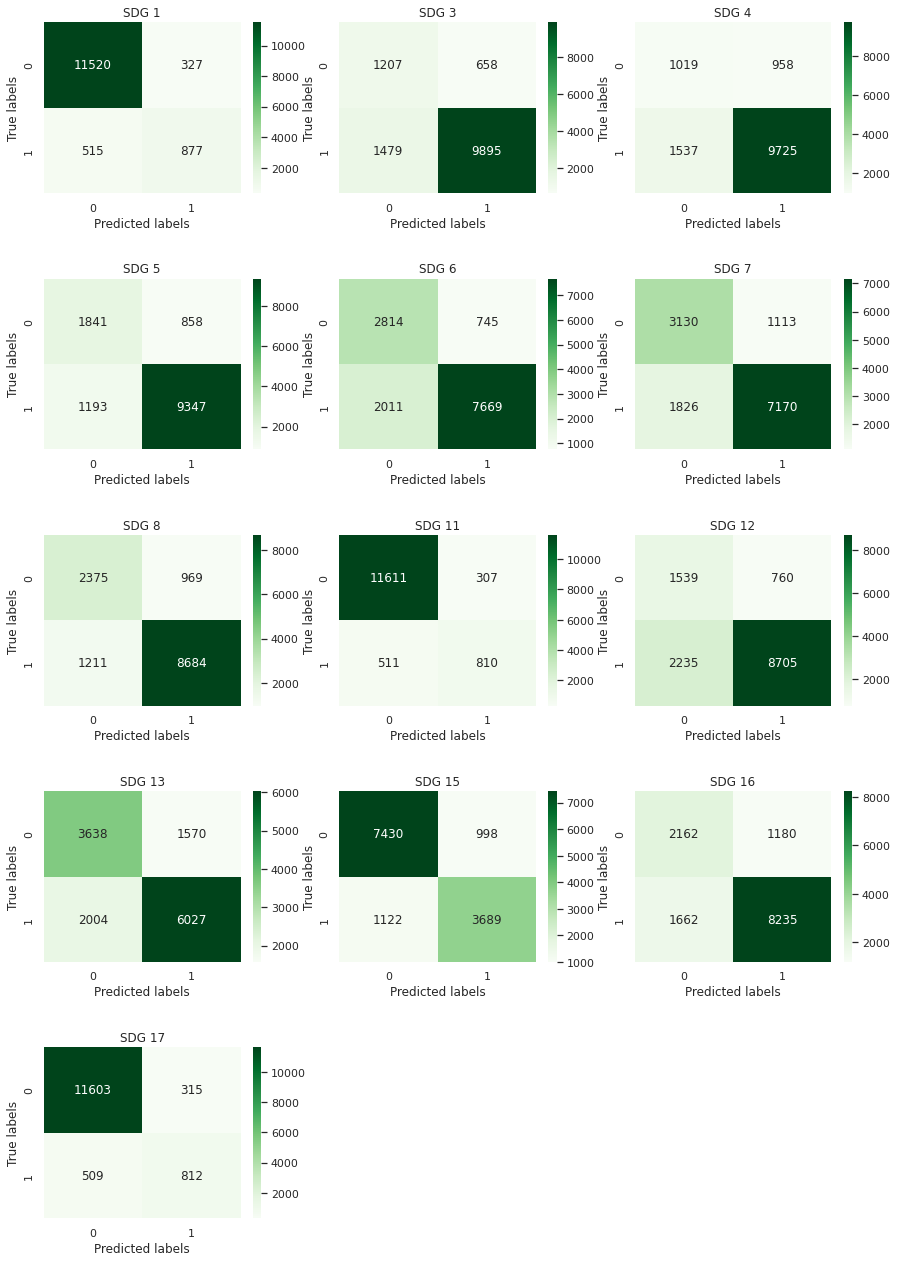

In [23]:
# Print classification report
print(classification_report(Y_test, predictions))

# Plot confusion matrices for each label
sdgs = [1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16, 17]
counter = 0
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 22))
plt.subplots_adjust(hspace=0.5)
for ax in axes.flatten():
    if counter <= 12:
        cm = confusion_matrix(true_labels[:, counter], predicted_labels[:, counter])
        sns.heatmap(cm, annot=True, fmt="g", ax=ax, cmap="Greens")
        ax.set_title("SDG " + str(sdgs[counter]))
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        counter += 1
    else:
        ax.set_visible(False)
        counter += 1